
# LendingClub Rejected Loans EDA

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)

# --- CONFIG ---
REJECTED_PATH = "../data/rejected_2007_to_2018Q4.csv" 

RANDOM_SEED = 42


## Data Loading

In [ ]:
dtype_map = {
    "Amount Requested": "string",
    "Loan Title": "string",
    "Risk_Score": "string",
    "Debt-To-Income Ratio": "string",
    "Zip Code": "string",
    "State": "string",
    "Employment Length": "string",
    "Policy Code": "string"
}
usecols = list(dtype_map.keys()) + ["Application Date"]
df = pd.read_csv(REJECTED_PATH, usecols=usecols, dtype=dtype_map, low_memory=True)

## Helper functions

In [ ]:
def to_float_amount(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("$", "").replace(",", "").strip()
    return pd.to_numeric(s, errors="coerce")

def to_float_percent(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("%", "").strip()
    return pd.to_numeric(s, errors="coerce")

def parse_emp_len(s):
    # "10+ years", "3 years", "< 1 year", "n/a"
    if pd.isna(s): return np.nan
    t = str(s).lower().strip()
    if "10" in t: return 10
    if "<" in t or "less" in t: return 0
    num = pd.to_numeric("".join(ch for ch in t if ch.isdigit()), errors="coerce")
    return num

## Typer Conversions

In [ ]:
df["app_date"]    = pd.to_datetime(df["Application Date"], errors="coerce", infer_datetime_format=True)
df["app_year"]    = df["app_date"].dt.year
df["app_month"]   = df["app_date"].dt.to_period("M")

df["amount_req"]  = df["Amount Requested"].map(to_float_amount)
df["dti"]         = df["Debt-To-Income Ratio"].map(to_float_percent)
df["risk_score"]  = pd.to_numeric(df["Risk_Score"], errors="coerce")
df["emp_len_yrs"] = df["Employment Length"].map(parse_emp_len).astype("float")
df["zip3"]        = df["Zip Code"].str.extract(r"(\d{3})")
df["state"]       = df["State"].str.upper().str.strip()
df["policy_code"] = pd.to_numeric(df["Policy Code"], errors="coerce")

## Data filtering

In [ ]:
# ---------- 4) Filter to 2017–2018 & sample 50k ----------
df = df[df["app_year"].isin([2017, 2018])].copy()
df = df[~df["app_year"].isna()].copy()
TARGET_N = 50_000
if len(df) > TARGET_N:
    df = df.sample(n=TARGET_N, random_state=42)

## Bands for policy views

In [ ]:
amount_bins = [0, 2500, 5000, 10000, 15000, 25000, 40000, np.inf]
amount_lbls = ["≤2.5k","2.5–5k","5–10k","10–15k","15–25k","25–40k",">40k"]
df["amount_band"] = pd.cut(df["amount_req"], bins=amount_bins, labels=amount_lbls, right=True, include_lowest=True)

dti_bins = [0, 15, 25, 35, 40, 45, 50, np.inf]
dti_lbls = ["≤15%","15–25%","25–35%","35–40%","40–45%","45–50%",">50%"]
df["dti_band"] = pd.cut(df["dti"], bins=dti_bins, labels=dti_lbls, right=False)

score_bins = [0, 580, 620, 660, 700, 740, 780, 990]
score_lbls = ["<580","580–619","620–659","660–699","700–739","740–779","≥780"]
df["score_band"] = pd.cut(df["risk_score"], bins=score_bins, labels=score_lbls, right=True, include_lowest=True)

emp_bins = [-1,0,1,2,5,10]
emp_lbls = ["<1y","1y","2y","3–5y","≥6y(≤10)"]
df["emp_band"] = pd.cut(df["emp_len_yrs"], bins=emp_bins, labels=emp_lbls)

## PLOTS

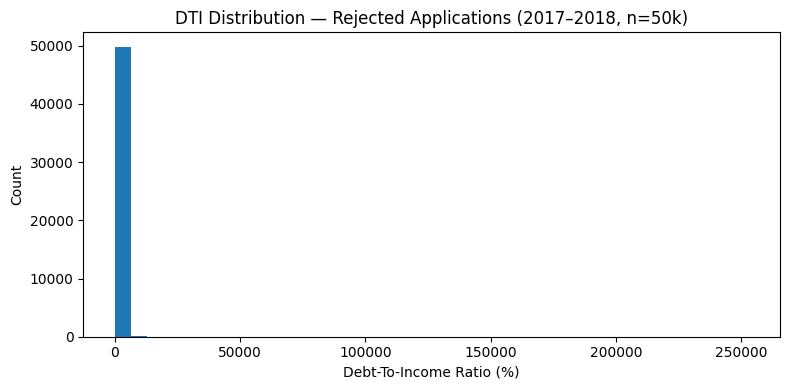

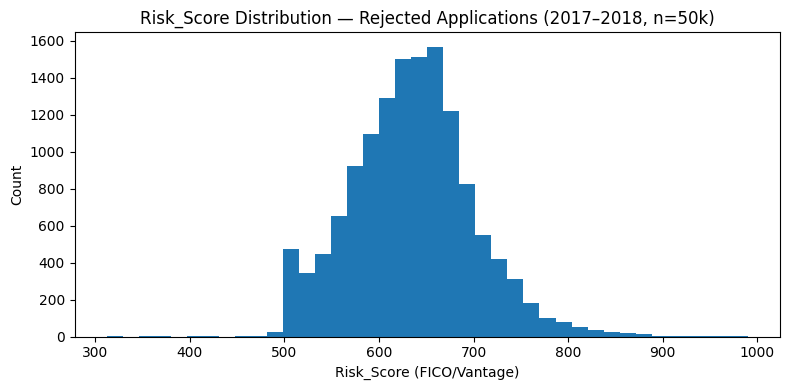

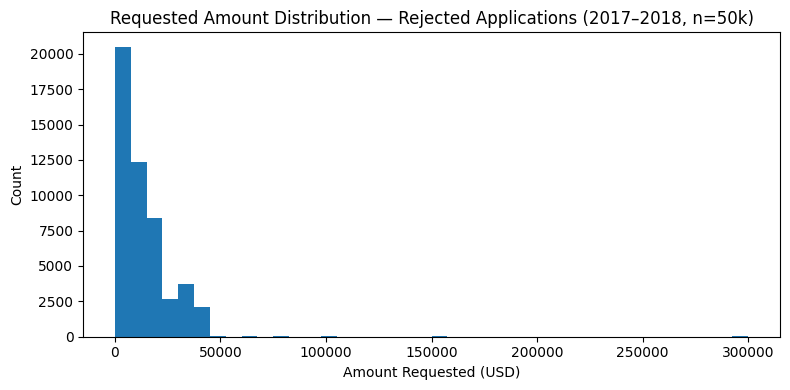

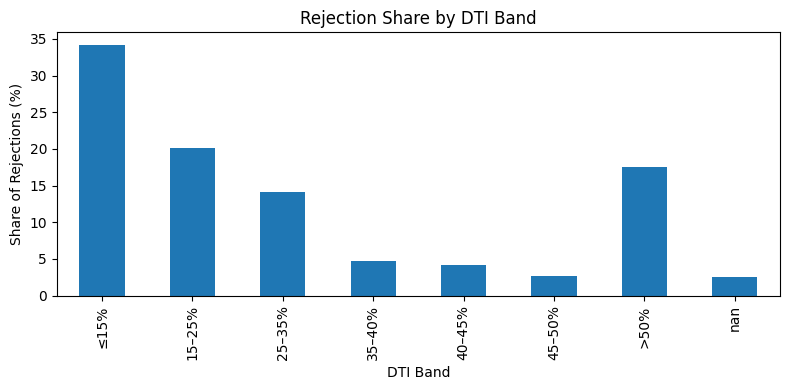

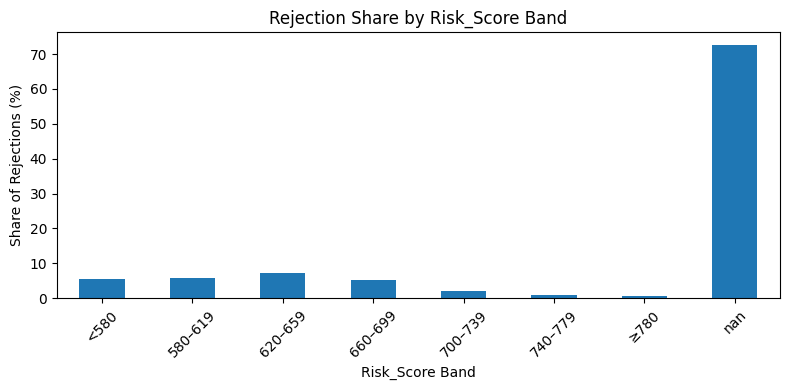

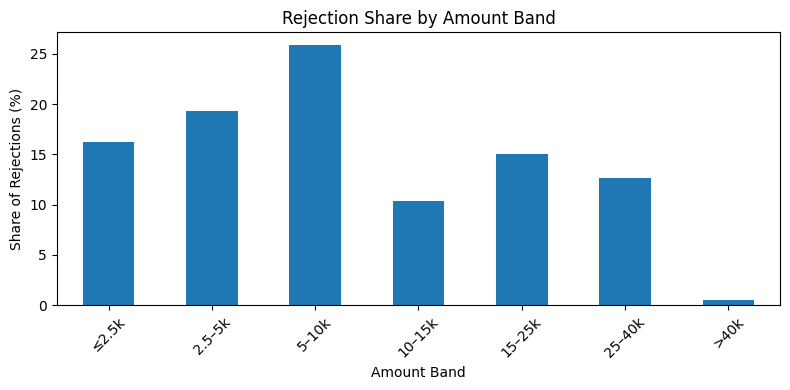

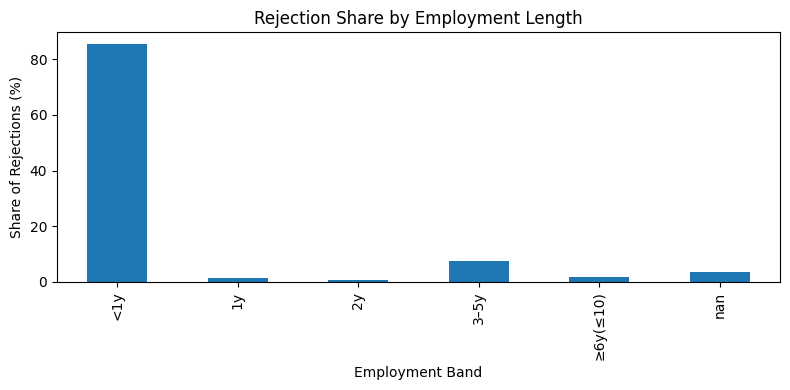

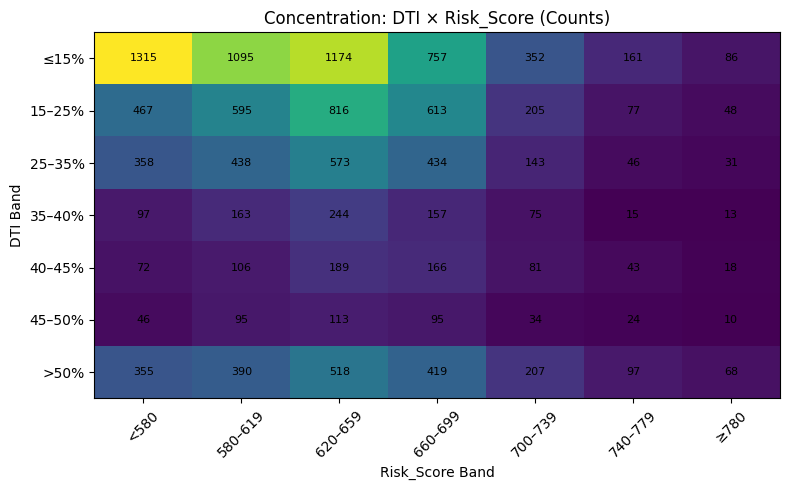

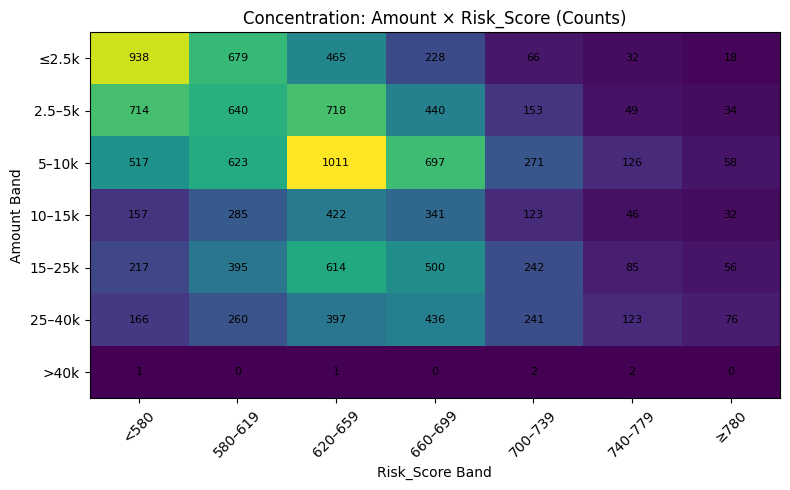

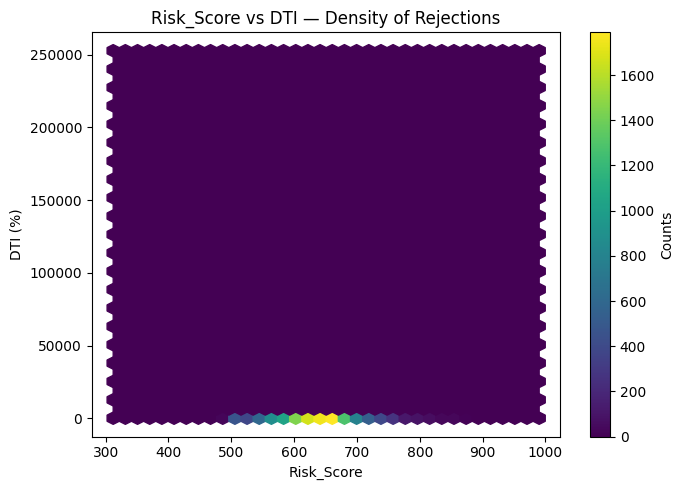

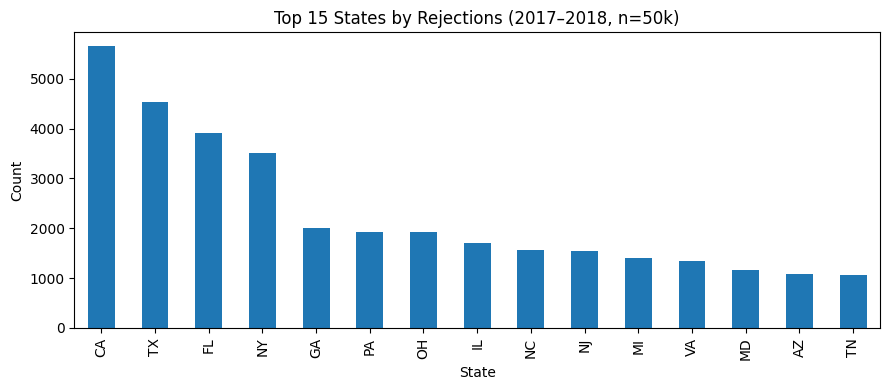

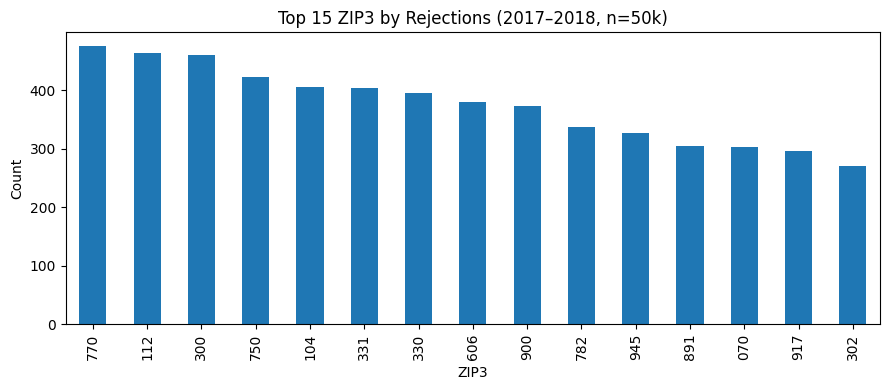

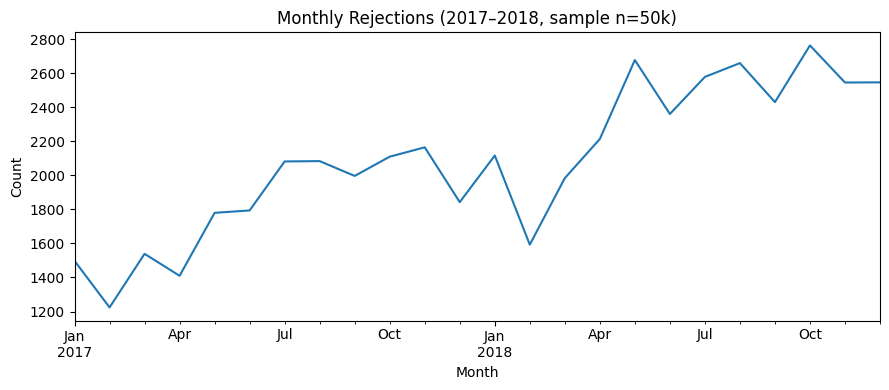

Done.


In [ ]:
# --- A) Distribution snapshots (DTI, Risk Score, Amount) ---
plt.figure(figsize=(8,4))
df["dti"].dropna().plot(kind="hist", bins=40)
plt.title("DTI Distribution — Rejected Applications (2017–2018, n=50k)")
plt.xlabel("Debt-To-Income Ratio (%)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df["risk_score"].dropna().plot(kind="hist", bins=40)
plt.title("Risk_Score Distribution — Rejected Applications (2017–2018, n=50k)")
plt.xlabel("Risk_Score (FICO/Vantage)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
df["amount_req"].dropna().plot(kind="hist", bins=40)
plt.title("Requested Amount Distribution — Rejected Applications (2017–2018, n=50k)")
plt.xlabel("Amount Requested (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- B) Policy bars: shares by band (DTI, Score, Amount, Employment) ---
def bar_share(series, title, xlabel, rotation=0):
    counts = series.value_counts(dropna=False).sort_index()
    shares = (counts / counts.sum() * 100).round(2)
    plt.figure(figsize=(8,4))
    shares.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Share of Rejections (%)")
    if rotation:
        plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

bar_share(df["dti_band"],    "Rejection Share by DTI Band", "DTI Band")
bar_share(df["score_band"],  "Rejection Share by Risk_Score Band", "Risk_Score Band", rotation=45)
bar_share(df["amount_band"], "Rejection Share by Amount Band", "Amount Band", rotation=45)
bar_share(df["emp_band"],    "Rejection Share by Employment Length", "Employment Band")

# --- C) Two-way concentration (policy matrices) ---
# DTI × Score (counts heatmap-like)
pivot_dti_score = (df.groupby(["dti_band","score_band"]).size()
                     .unstack("score_band", fill_value=0)
                     .reindex(index=dti_lbls, columns=score_lbls))
plt.figure(figsize=(8,5))
plt.imshow(pivot_dti_score.values, aspect="auto")
plt.title("Concentration: DTI × Risk_Score (Counts)")
plt.xlabel("Risk_Score Band")
plt.ylabel("DTI Band")
plt.xticks(ticks=np.arange(len(score_lbls)), labels=score_lbls, rotation=45)
plt.yticks(ticks=np.arange(len(dti_lbls)), labels=dti_lbls)
for i in range(pivot_dti_score.shape[0]):
    for j in range(pivot_dti_score.shape[1]):
        val = int(pivot_dti_score.values[i, j])
        plt.text(j, i, f"{val}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# Amount × Score (counts heatmap-like)
pivot_amt_score = (df.groupby(["amount_band","score_band"]).size()
                     .unstack("score_band", fill_value=0)
                     .reindex(index=amount_lbls, columns=score_lbls))
plt.figure(figsize=(8,5))
plt.imshow(pivot_amt_score.values, aspect="auto")
plt.title("Concentration: Amount × Risk_Score (Counts)")
plt.xlabel("Risk_Score Band")
plt.ylabel("Amount Band")
plt.xticks(ticks=np.arange(len(score_lbls)), labels=score_lbls, rotation=45)
plt.yticks(ticks=np.arange(len(amount_lbls)), labels=amount_lbls)
for i in range(pivot_amt_score.shape[0]):
    for j in range(pivot_amt_score.shape[1]):
        val = int(pivot_amt_score.values[i, j])
        plt.text(j, i, f"{val}", ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# --- D) Dense pattern view: Score vs DTI (hexbin)
plt.figure(figsize=(7,5))
valid = df[["risk_score","dti"]].dropna()
plt.hexbin(valid["risk_score"], valid["dti"], gridsize=35)
plt.title("Risk_Score vs DTI — Density of Rejections")
plt.xlabel("Risk_Score")
plt.ylabel("DTI (%)")
cb = plt.colorbar()
cb.set_label("Counts")
plt.tight_layout()
plt.show()

# --- E) Geography (optional quick wins): Top states, Top ZIP3s ---
top_states = df["state"].value_counts().head(15)
plt.figure(figsize=(9,4))
top_states.plot(kind="bar")
plt.title("Top 15 States by Rejections (2017–2018, n=50k)")
plt.xlabel("State")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

top_zip3 = df["zip3"].value_counts().head(15)
plt.figure(figsize=(9,4))
top_zip3.plot(kind="bar")
plt.title("Top 15 ZIP3 by Rejections (2017–2018, n=50k)")
plt.xlabel("ZIP3")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- F) Seasonality (capacity planning) ---
monthly = df.groupby("app_month").size().rename("rejections").to_timestamp()
plt.figure(figsize=(9,4))
monthly.plot()
plt.title("Monthly Rejections (2017–2018, sample n=50k)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
# ===========================================================================

print("Done.")


1. **Risk score missingness is huge**

   * The “Risk_Score band” bar has a massive **NaN column** (dominant share).
   * Among the non-missing scores, the histogram is bell-shaped ~**580–720** with a hump around **620–680**.
     **Implication:** You can’t rely on score alone; a **fallback path** is required when no score is present.

2. **DTI alone doesn’t explain most declines**

   * The DTI histogram is blown out by extreme outliers (axis up to 250k% → clear data noise), but the **banded chart** shows most rejections in **≤15%** and **15–25%** buckets, with another bump **>50%**.
     **Implication:** Many declines happen even at **low DTI**—so the decision is driven by other factors (credit score when available, thin file, short employment, fraud checks, policy_code=2 products, etc.). Also, you need a **DTI cap** and **data cleaning** (winsorize DTI at ~150–200%, drop negatives).

3. **Employment length: very short tenure dominates**

   * The “Employment Length” bar has an **outsized `<1y` share**.
     **Implication:** New/short job tenure is a common feature among rejects. Use a **verify-then-decide** rule (extra docs, co-applicant, smaller amount) for **emp_len < 2y**, rather than blanket declines in middle score bands.

4. **Amount profile: most declines are small–mid tickets**

   * Peak rejection share at **$5–10k**, then **$2.5–5k**; **>$40k** is rare.
     **Implication:** Rejections mirror application volume (not only large-amount risk). To salvage volume, enable **counter-offers** even in the **$2.5–10k** range for borderline profiles (e.g., reduce to cell-level 60–80th percentile).

5. **Concentration matrices pinpoint the common reject profile**

   * **DTI × Risk_Score**: highest counts at **DTI ≤25%** with **scores ~620–699**.
   * **Amount × Risk_Score**: highest around **$2.5–10k** with **scores ~620–699**.
     **Implication:** The modal rejected applicant is **mid-score (620–699), low-to-moderate DTI (≤25%), and asks for $2.5–10k**. That suggests a **score floor** is the main gate; DTI is not the binding constraint for many rejections.

6. **Seasonality & geography**

   * Monthly line shows **higher volumes in 2018** with visible peaks → plan **seasonal underwriting capacity**.
   * Top-state / top-ZIP3 bars (CA, TX, FL, NY, …) look volume-driven; still useful for **geo overlays** (e.g., extra verification in top-decile ZIP3s).

# Policy moves I’d recommend

* **P1 — Score-first grid with a no-score fallback**

  * Define a **three-zone matrix** on **(Risk_Score band × DTI band)**: *approve / verify / decline*.
  * For **missing scores**, route to a **fallback rule**: require income docs + employment verification; apply **tighter DTI caps** and **lower amount caps** until alternative score is obtained.

* **P2 — DTI hygiene + caps**

  * **Clean DTI** (cap/winsorize at 150–200%, drop negatives) for analytics and monitoring.
  * Enforce **hard decline at DTI ≥45–50%**; **verify** for **40–45%**; standard review below that.

* **P3 — Employment tenure overlay**

  * If **emp_len < 2y** and score is **620–659**, default to **verify** (paystubs, contract) and **offer reduced amount** rather than auto-decline.
  * If **emp_len < 1y** and **no score**, **tight cap** (e.g., ≤$2.5–5k) or decline unless strong compensating factors.

* **P4 — Counter-offer playbook**

  * In **620–699** score bands, auto-suggest **reduced amounts** (e.g., 60–80th percentile for that band) to convert borderline declines, especially in the **$2.5–10k** region.

* **P5 — Capacity & geo**

  * **Pre-tune thresholds** ahead of peak months and staff up reviewers.
  * Pilot **geo-aware verification** in top-decile ZIP3s by reject volume.